# Benchmark Result Visualization

#### Imports

In [1]:
import json
import os
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow_similarity.benchmark import Result
from tensorflow_similarity.visualization import *
import pandas as pd
from collections import defaultdict
import plotly.express as px
import itertools
import altair as alt
import plotly.graph_objects as go

# enable us to visualize more than 5,000 items for Altair
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

#### Read in the Result object

In [2]:
output_file_name = "long_example_output.txt"

In [3]:
with open(output_file_name) as fp:
    results_paths = [line.rstrip('\n') for line in fp.readlines()]

In [4]:
# read the jsons into the Tensorflow Similarity Benchmark Result object
results = [Result.read(path) for path in results_paths]

#### Visualize the Configurations

Those are configruations to the experiment provided by the users

In [5]:
def tabulate_information(information, headers=['Specification', 'Configuration(s)']):
    information_table = [[k, v] for k, v in information.items()]
    for row in information_table:
        if row[1] is None:
            row[1] = "None"
    print(tabulate(information_table, headers=headers) + '\n')

In [6]:
# Let's see what is recored in the result object
result = results[1]

In [7]:
tabulate_information(result.data_information)

Specification                Configuration(s)
---------------------------  ------------------
num_unseen_classes           [5, 20]
num_targets                  [1, 5]
training_classes_percentage  1.0
num_training_samples         100
dataset                      omniglot
num_seen_classes             964



In [8]:
tabulate_information(result.model_information)

Specification             Configuration(s)
------------------------  ----------------------
tower_model_architecture  VGG16
embedding_size            64
similarity_loss           stable_quadruplet_loss
auxiliary_task            None
tower_model_params        50636672
tower_model_layers        23



In [9]:
tabulate_information(result.training_information)

Specification      Configuration(s)
---------------  ------------------
num_epochs                  20
inference_time               0.9443



As we can see from above, the users specified what are the number of unseen and seen classes as while as the number of targets and training samples per class.

The `data_information` attribute provides information about the data that were used in the experiment. Informations include the number of classes seen (trained) and unseen (test), number of shots (targets), etc.

The `model_information` attribute provides information about the model used, such as the architecture of tower model, similarity loss used, etc.

The `training_information` attribute provides information about training, such as  the number of epochs trained.

#### Visualize metrics recorded

In [10]:
num_unseen_classes = result.get_num_unseen_classes()
num_targets = result.get_num_targets()
num_epochs = result.get_num_epochs()
num_training_samples = result.get_num_training_samples()

In [11]:
metrics_dict = defaultdict(list)
for result in results:
    for num_unseen_class, num_target in itertools.product(num_unseen_classes, num_targets):
        epoch = result.get_best_epoch(num_unseen_class, num_target)
        acc = result.get_best_accuracy(num_unseen_class, num_target)
        
        for key in result.model_information:
            metrics_dict[key].append(result.model_information[key])
        
        for key in result.data_information:
            if not type(result.data_information[key]) is list:
                metrics_dict[key].append(result.data_information[key])
                
        metrics_dict["ways"].append(num_unseen_class)
        metrics_dict["shots"].append(num_target)
        
        metrics_dict["epoch"].append(epoch)
        metrics_dict["accuracy"].append(acc)
        
df = pd.DataFrame(metrics_dict)

# term all columns except accuracy into string because
# plotly does not recognize integer as categorical
df = df.astype(str)
df[["accuracy"]] = df[["accuracy"]].apply(pd.to_numeric)

In [12]:
df.head()

tower_model_architecture embedding_size         similarity_loss  \
0                    VGG16             64  stable_quadruplet_loss   
1                    VGG16             64  stable_quadruplet_loss   
2                    VGG16             64  stable_quadruplet_loss   
3                    VGG16             64  stable_quadruplet_loss   
4                    VGG16             64  stable_quadruplet_loss   

  auxiliary_task tower_model_params tower_model_layers  \
0           None           40150912                 23   
1           None           40150912                 23   
2           None           40150912                 23   
3           None           40150912                 23   
4           None           50636672                 23   

  training_classes_percentage num_training_samples        dataset  \
0                         1.0                  100  mini_imagenet   
1                         1.0                  100  mini_imagenet   
2                         1.0                  100  mini_imagenet   
3                         1.0                  100  mini_imagenet   
4                         1.0                  100       omniglot   

  num_seen_classes ways shots epoch  accuracy  
0               64    5     1    10    0.2726  
1               64    5     5     3    0.2805  
2               64   20     1     3    0.0987  
3               64   20     5     4    0.0974  
4              964    5     1    10    1.0000

In [13]:
list(df.columns)

['tower_model_architecture',
 'embedding_size',
 'similarity_loss',
 'auxiliary_task',
 'tower_model_params',
 'tower_model_layers',
 'training_classes_percentage',
 'num_training_samples',
 'dataset',
 'num_seen_classes',
 'ways',
 'shots',
 'epoch',
 'accuracy']

Although there are many more information we are keeping (such as additional metrics like completeness, silhouette score, etc), the most important metric we want to compare to is the accuracy / loss. Currently we are not able to easily compute and save the loss for testing / validating dataset so we use accuracy as a proxy. Please see the [tf.similarity Benchmark Design Doc](https://docs.google.com/document/d/1rfamax2ZaGayh5nBsffrFB4c1e2QHtbKHPHilm1yKd4/edit#heading=h.al3hkodp657g) for further explanation of those those columns.

In [14]:
hover_data = ["ways", "shots", "tower_model_architecture", "embedding_size"]
fig = px.bar(df, x="similarity_loss", y="accuracy", color="dataset", barmode='group', height=400, hover_data=hover_data)
fig.show()

The above is a stacked bar chart (although not very helpful), that compares the results of benchmark on different datasets using different losses. We can see that across all losses tf.similarity performs well on omniglot but not so much on cifar100 or mini_imagenet. We can also see that stable_quadruplet_loss outperforms triplet and quadruplet losses. Although users are able to see what each "stacked" box are for which experiment when hover, this figure hides a lot of information. Therefore we are moving to the table visualization below to allow more flexibility.

**Why are we sorting dataset, ways, and shots?** We sort they because that is how the dataframe pivot table is sorted so it's easier to match.

In [26]:
datasets = df["dataset"].unique()
ways = df["ways"].unique()
shots = df["shots"].unique()

datasets.sort()
ways.sort()
shots.sort()

In almost all of the research paper on few-shot lerning, see [Few-Shot Learner Industry Benchmark](https://docs.google.com/spreadsheets/d/1z2DRPhtMhKRHWcOLvTjHI7RKuefCw2VXXEBbWMV6OWs/edit#gid=0). They all use 3 main datasets for benchmark (mini imageNet, cifar100(FS), and omniglot). And use the combination of 5-ways, 1,5-shots. (and 20 ways for omniglot). Therefore in order to match the format of what other research paper are recording their benchmark data, we want to set dataset, number of ways and number of shots as the columns and each row will be an experiment (or aggregated), and the value for the table be the accuracy.

In [27]:
# color to separate each dataset, using Google's color.
blue_hex = "#4285F4"
red_hex = "#DB4437"
green_hex = "#0F9D58"
yellow_hex = "#F4B400"
header_colors = [blue_hex, red_hex, green_hex, yellow_hex]

**Possible dimensions are:**

* similarity_loss
* tower_model_architecture
* embedding_size
* training_classes_percentage/num_seen_classes (those 2 are directly correlated)
* num_training_samples

In the current implmentation we are using the **max** aggregation function to aggregate multiple experiments matching the same dimensions into one row (i.e. if we run 2 experiments with the configuration of triplet_loss, VGG16, we will use the max aggregation function to display the rows)

**Why using Plotly?** Plotly provides an easy way for users to save the plots as jpg (just press the camera icon on the top left).

In [28]:
dimensions = ["similarity_loss", "tower_model_architecture", 'embedding_size', 'training_classes_percentage']

# the first row is for the name of algorithm
header_rows = len(datasets) * len(ways) * len(shots) + len(dimensions)
header_cols = 3
header_values = np.full((header_rows, header_cols), dtype=object, fill_value="")
header_fill_color = np.full((header_rows, header_cols), dtype=object, fill_value="grey")
for i, dataset in enumerate(datasets):
    # update the dataset row
    dataset_idx = i * len(ways) * len(shots) + len(dimensions)
    header_values[dataset_idx][0] = dataset.replace("_", " ")
    
    dataset_color = header_colors[i % len(datasets)]
    
    for j, way in enumerate(ways):
        way_idx = j * len(shots) + dataset_idx
        header_values[way_idx][1] = "{}way".format(way)
        
        for k, shot in enumerate(shots):
            shot_idx = k + way_idx
            header_values[shot_idx][2] = "{}shot".format(shot)
            
            header_fill_color[shot_idx] = np.full(3, fill_value=dataset_color)
            
for index, dimension in enumerate(dimensions):
    header_values[index][-1] = dimension.replace("_", " ")

column_names = ["dataset", "ways", "shots"]
pivot_table = pd.pivot_table(df, values="accuracy", index=dimensions, columns=column_names, aggfunc=np.max)
cell_cols = len(pivot_table)
cell_values = np.zeros((header_rows, cell_cols), dtype=object)

for index, (configuration, row) in enumerate(pivot_table.iterrows()):
    if isinstance(configuration, str):
        cell_values[:len(dimensions), index] = [configuration.replace("_", " ")]
    else:
        cell_values[:len(dimensions), index] = [string.replace("_", " ") for string in configuration]
    
    row_values = row.tolist()
    cell_values[len(dimensions):, index] = ["{0:.2%}".format(value) for value in row_values]

fig = go.Figure(data=[go.Table(
    header=dict(
        values=header_values,
        fill_color=header_fill_color,
        align="left",
        font_color="white",
        line_width=0,
    ),
    cells=dict(
        values = cell_values,
        align="left",
        
    )
)])

fig.update_layout(width=1200, height=800)
fig.show()

**Using pandas internal pivot_table method**

In [18]:
# pandas built in pivot table representation of above table.
table = pd.pivot_table(df, values='accuracy', index=dimensions, columns=["dataset", "ways", "shots"], aggfunc=np.max)

table.head()

dataset                                                                                    cifar100  \
ways                                                                                             20   
shots                                                                                             1   
similarity_loss        tower_model_architecture embedding_size training_classes_percentage            
quadruplet_loss        VGG16                    32             1.0                           0.1205   
                                                64             1.0                           0.1200   
stable_quadruplet_loss VGG16                    32             1.0                           0.1376   
                                                64             1.0                           0.1154   
triplet_loss           VGG16                    32             1.0                           0.1278   

dataset                                                                                             \
ways                                                                                                 
shots                                                                                            5   
similarity_loss        tower_model_architecture embedding_size training_classes_percentage           
quadruplet_loss        VGG16                    32             1.0                          0.1182   
                                                64             1.0                          0.1169   
stable_quadruplet_loss VGG16                    32             1.0                          0.1614   
                                                64             1.0                          0.1454   
triplet_loss           VGG16                    32             1.0                          0.1237   

dataset                                                                                             \
ways                                                                                             5   
shots                                                                                            1   
similarity_loss        tower_model_architecture embedding_size training_classes_percentage           
quadruplet_loss        VGG16                    32             1.0                          0.3088   
                                                64             1.0                          0.3259   
stable_quadruplet_loss VGG16                    32             1.0                          0.2888   
                                                64             1.0                          0.3215   
triplet_loss           VGG16                    32             1.0                          0.5429   

dataset                                                                                             \
ways                                                                                                 
shots                                                                                            5   
similarity_loss        tower_model_architecture embedding_size training_classes_percentage           
quadruplet_loss        VGG16                    32             1.0                          0.3136   
                                                64             1.0                          0.3422   
stable_quadruplet_loss VGG16                    32             1.0                          0.3180   
                                                64             1.0                          0.3429   
triplet_loss           VGG16                    32             1.0                          0.5412   

dataset                                                                                    mini_imagenet  \
ways                                                                                                  20   
shots                                                                                              

The above pivot table contains the same information as the Plotly table. But this pivot table cannot be exported as an image.

#### Visualize embedding at best accuracy

In the benchmark Result object we also stored the target and test embeddings so that the users are able to utilize the visualization subpackage (which takes in embeddings) to visualize the embeddings for each particular experiment.

In [19]:
# Let's see what is recored in the result object
result = results[3]

In [20]:
tabulate_information(result.data_information)
tabulate_information(result.model_information)
tabulate_information(result.training_information)

Specification                Configuration(s)
---------------------------  ------------------
num_unseen_classes           [5, 20]
num_targets                  [1, 5]
training_classes_percentage  1.0
num_training_samples         100
dataset                      mini_imagenet
num_seen_classes             64

Specification             Configuration(s)
------------------------  ------------------
tower_model_architecture  VGG16
embedding_size            64
similarity_loss           triplet_loss
auxiliary_task            None
tower_model_params        40150912
tower_model_layers        23

Specification      Configuration(s)
---------------  ------------------
num_epochs                  20
inference_time               4.8435



In [21]:
(targets_embeddings, y_targets), (test_embeddings, y_test) = result.get_best_embeddings(num_unseen_classes[-1], num_targets[-1])

In [22]:
len(test_embeddings)

11880

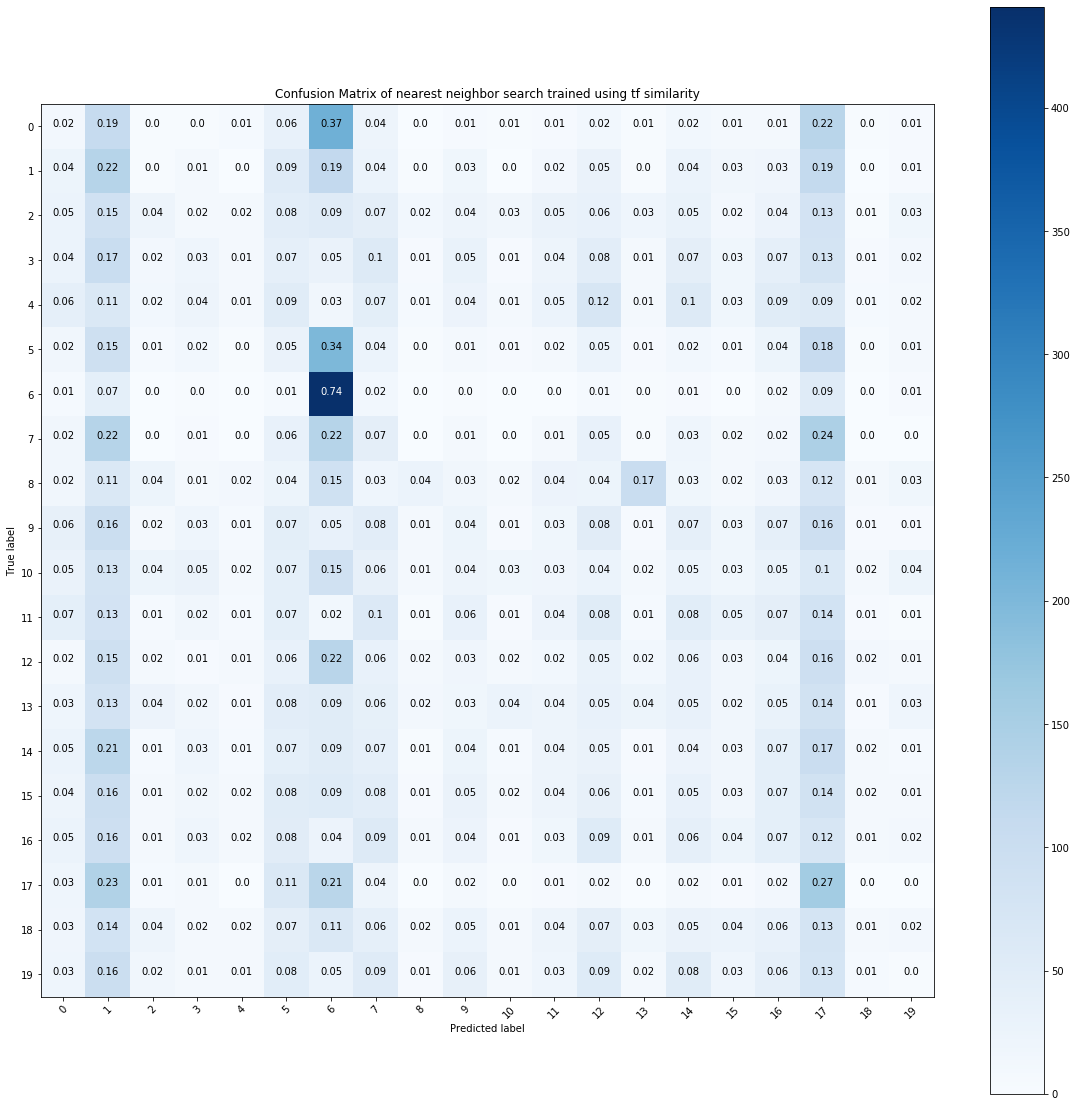

In [23]:
title = "Confusion Matrix of nearest neighbor search trained using tf similarity"
figure = plot_confusion_matrix(test_embeddings, y_test, targets_embeddings, y_targets, title)
figure

In [24]:
title = "2D Embedding Projector of NMIST dataset"
interactive=True #@param {type:"boolean"}
num_steps_tsne = 10000 #@param {type:"integer"}
figure = plot_embedding_projector(test_embeddings, y_test, title=title, interactive=interactive, num_steps=num_steps_tsne)
figure

alt.HConcatChart(...)

In [25]:
title = "Nearest neighbors table of targets trained using tf similarity"
num_neighbors = 8 #@param {type:"integer"}
figure = plot_nearest_neighbors_table(test_embeddings, y_test, targets_embeddings, y_targets, title, num_neighbors)
figure

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()